In this example we will train emotion classification model based on The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) dataset ([reference](https://zenodo.org/record/1188976))

## Downloading and installing the **voice_characterizer** library

In [2]:
%%capture --no-stderr
!wget "https://drive.google.com/uc?id=1eSUaR76FXeZT3G_fLKUSVX5s9kPvN3FF" -O "/content/voice_characterizer-0.53-py3-none-any.whl"
!pip install "/content/voice_characterizer-0.53-py3-none-any.whl"

## Installing prerequisites
We will convert audio format in preprocessing, there is a need to install the **ffmpeg** utility.

In [3]:
#@title <font size="4"><i>Installing ffmpeg</font><br/><font size="3">Taken from <a href="https://colab.research.google.com/github/yunooooo/FFmpeg-for-Google-Drive/blob/master/FFmpeg.ipynb">here</a></font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


## Downloading the dataset


In [18]:
# %%capture --no-stderr
dataset_dir = "dataset"
!mkdir $dataset_dir
# # download the dataset
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1 -O $dataset_dir"/Audio_Speech_Actors_01-24.zip"
# unzip and remove the archive
!unzip -qq $dataset_dir"/Audio_Speech_Actors_01-24.zip" -d $dataset_dir
!rm $dataset_dir"/Audio_Speech_Actors_01-24.zip"
# move the files from subfolders to "./dataset"
!find $dataset_dir -type f -mindepth 2 -exec mv -i -- {} $dataset_dir \;
# remove redundant directories
!find $dataset_dir -depth -mindepth 1 -type d -empty -exec rmdir {} \;

# Create a mapping DataFrame

In [32]:
import pandas as pd
# Filename identifiers:
#   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
#   Vocal channel (01 = speech, 02 = song).
#   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
#   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
#   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
#   Repetition (01 = 1st repetition, 02 = 2nd repetition).
#   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

file_emotion = []
file_path = []
ravdess_directory_list = os.listdir(dataset_dir)
for f in ravdess_directory_list:
  parts = f.split('.')[0].split('-')
  file_emotion.append(int(parts[2]))
  file_path.append(dataset_dir + '/' + f)
        
ravdess_df = pd.DataFrame(list(zip(file_emotion, file_path)), columns=['emotion', 'path'])

# mapping to textual labels
ravdess_df['emotion'] = ravdess_df['emotion'].replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'})
ravdess_df.head()

,emotion,path
0,surprised,dataset/03-01-08-01-02-02-04.wav
1,fearful,dataset/03-01-06-01-01-02-19.wav
2,sad,dataset/03-01-04-01-01-01-22.wav
3,angry,dataset/03-01-05-01-02-02-21.wav
4,disgust,dataset/03-01-07-01-02-01-24.wav


## Running the voice characterization pipeline

In [34]:
%%capture --no-stderr
# get the pipline configuration file
!wget "https://drive.google.com/uc?id=1Kqklx_4aQQPXuleRFU0bkJETajeFlStg" -O "/content/pipeline.yaml"
# change the input_dir in the configuration
!sed -E -i "s/input_dir: '[0-9a-zA-Z_]+'/input_dir: \'"$dataset_dir"\'/g" "/content/pipeline.yaml"

In [47]:
import yaml
import logging
logging.basicConfig(level=logging.INFO)  # You can configure the log-level to
                                         # reach the desired verbosity
from audio_pipeline.core.ClassificationPipline import ClassificationPipeline
from audio_pipeline.core.FeatureExtractionPipline import FeatureExtractionPipeline
from audio_pipeline.core.PreprocessPipline import PreprocessPipeline
from audio_pipeline.core.CombinedPipeline import CombinedPipeline


# loading the configuration of the pipeline and its components from pipline.yaml
with open('pipeline.yaml', 'r') as f:
  config = yaml.load(f, Loader=yaml.FullLoader)

# declaring the preprocessing pipeline
preprocessing_pipeline = PreprocessPipeline(
  ['file_mapper', 'wav_converter'], config=config)
# declaring the feature extraction pipeline
# this is required for the training set generation or whether one of the models
# is expecting the features as input (e.g. 'common_voices_gender')
feature_extraction_pipeline = FeatureExtractionPipeline(
  ['pyannote_embedding'], config=config)
# # declaring the classification pipeline
# # some of the classifiers use the features columns and others preprocessed files
# speaker_clf_pipeline = ClassificationPipeline(
#   ['common_voices_gender', 'common_voices_age', 'speech_brain_iemocap_emotion'], 
#   config=config)

# combining all of the pipelines together
pipline = CombinedPipeline(
  [preprocessing_pipeline, feature_extraction_pipeline],
  config=config)
# executing pipeline
processed_payload = pipline.process()

INFO:PreprocessPipeline:Created Preprocessing Pipeline with 2 components
INFO:FeatureExtractionPipeline:Created Feature Extraction Pipeline with 1 components
INFO:PreprocessPipeline:Processing with file_mapper
INFO:PreprocessPipeline:Processing with wav_converter
INFO:FeatureExtractionPipeline:Processing with pyannote_embedding


Downloading:   0%|          | 0.00/96.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmptedbhjwn
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmptedbhjwn/_remote_module_non_sriptable.py
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-08-01-02-02-04.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-06-01-01-02-19.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-04-01-01-01-22.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-05-01-02-02-21.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-07-01-02-01-24.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-04-01-02-02-09.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-02-01-02-02-10.wav
INFO:feature_extraction - pyannote_embedding:done with convert_preprocessed/03-01-05-02-02-01-23.wav

In [57]:
payload_df = processed_payload.get_features_df()
payload_df

,wav_converter_processed_path,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,convert_preprocessed/03-01-08-01-02-02-04.wav,23.146645,-8.613534,-23.908855,-32.521374,-93.114868,8.989367,-54.400127,1.449403,31.715637,...,31.684498,73.064651,7.383377,-22.593693,-14.096283,-67.800247,-49.370487,14.977894,-15.063391,-5.872006
1,convert_preprocessed/03-01-06-01-01-02-19.wav,-32.976135,0.328395,-19.516022,-59.334579,4.412902,-17.903637,-42.284687,-10.733599,20.109673,...,-51.529182,85.819946,-7.634048,15.542105,19.028023,-58.542538,-7.980512,43.133728,-8.046138,-0.125147
2,convert_preprocessed/03-01-04-01-01-01-22.wav,-3.491938,-17.494659,-39.987457,-63.798195,24.596106,-46.585674,50.355034,-25.393478,85.102249,...,-19.343632,-0.553608,-28.225412,13.447911,16.018600,-67.213013,-54.216637,53.594170,113.832275,-82.831619
3,convert_preprocessed/03-01-05-01-02-02-21.wav,-5.700679,-17.780893,35.155315,-68.135109,-2.687543,26.125317,-78.755936,20.248791,53.264179,...,-12.933208,14.531818,-26.286703,98.558090,-14.559208,8.108367,40.018181,42.750336,47.613274,-14.804508
4,convert_preprocessed/03-01-07-01-02-01-24.wav,34.503384,4.203001,93.901985,-22.365349,62.314182,-16.058771,-11.164144,-2.294779,-12.799766,...,36.553341,-120.724365,34.938446,7.758528,-18.943083,-44.343250,-26.973480,-24.694464,66.150833,89.168434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,convert_preprocessed/03-01-03-02-01-01-08.wav,27.551708,-49.802414,44.841858,-15.478889,-7.727461,-30.352945,-29.950016,-63.671463,15.222085,...,16.577780,7.087097,3.558476,-103.407692,18.420021,-59.261490,-100.142868,36.093464,8.285068,26.721886
1436,convert_preprocessed/03-01-04-02-02-02-22.wav,39.807747,-87.619400,-51.457855,-67.707664,4.096837,-79.271057,39.406116,-26.497366,58.280266,...,9.120522,16.017143,8.497351,1.602524,-33.116673,-50.165741,-12.468250,15.721325,49.267654,-46.580231
1437,convert_preprocessed/03-01-05-02-02-02-09.wav,-34.358833,78.625671,-58.679451,-29.959957,-66.696053,-59.138805,-8.001226,0.217263,23.856882,...,20.362978,51.026470,-23.068855,80.297302,-0.683223,-47.820374,-43.651978,73.167122,4.365999,-44.646858
1438,convert_preprocessed/03-01-08-01-02-02-14.wav,67.477646,-29.592560,-20.905617,-8.717731,-7.998135,5.906280,-23.108444,65.621414,-7.345996,...,19.483789,-18.677277,93.961296,-50.509361,-25.690266,-88.020447,-91.463631,39.372440,2.300965,-33.821716


In [62]:
try:
  ravdess_df['filename'] = ravdess_df['path'].apply(lambda x: x.split("/")[-1])
  payload_df['filename'] = payload_df['wav_converter_processed_path'].apply(lambda x: x.split("/")[-1])
except KeyError:
  pass

ravdess_df = ravdess_df.drop(['path'], axis=1, errors='ignore')
payload_df = payload_df.drop(['wav_converter_processed_path'], axis=1, errors='ignore')
merged_df = pd.merge(left=payload_df, right=ravdess_df, left_on='filename', right_on='filename').drop(['filename'], axis=1)
merged_df

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,emotion
0,23.146645,-8.613534,-23.908855,-32.521374,-93.114868,8.989367,-54.400127,1.449403,31.715637,34.857418,...,73.064651,7.383377,-22.593693,-14.096283,-67.800247,-49.370487,14.977894,-15.063391,-5.872006,surprised
1,-32.976135,0.328395,-19.516022,-59.334579,4.412902,-17.903637,-42.284687,-10.733599,20.109673,-5.917655,...,85.819946,-7.634048,15.542105,19.028023,-58.542538,-7.980512,43.133728,-8.046138,-0.125147,fearful
2,-3.491938,-17.494659,-39.987457,-63.798195,24.596106,-46.585674,50.355034,-25.393478,85.102249,-27.729828,...,-0.553608,-28.225412,13.447911,16.018600,-67.213013,-54.216637,53.594170,113.832275,-82.831619,sad
3,-5.700679,-17.780893,35.155315,-68.135109,-2.687543,26.125317,-78.755936,20.248791,53.264179,0.413782,...,14.531818,-26.286703,98.558090,-14.559208,8.108367,40.018181,42.750336,47.613274,-14.804508,angry
4,34.503384,4.203001,93.901985,-22.365349,62.314182,-16.058771,-11.164144,-2.294779,-12.799766,50.400848,...,-120.724365,34.938446,7.758528,-18.943083,-44.343250,-26.973480,-24.694464,66.150833,89.168434,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,27.551708,-49.802414,44.841858,-15.478889,-7.727461,-30.352945,-29.950016,-63.671463,15.222085,-43.118557,...,7.087097,3.558476,-103.407692,18.420021,-59.261490,-100.142868,36.093464,8.285068,26.721886,happy
1436,39.807747,-87.619400,-51.457855,-67.707664,4.096837,-79.271057,39.406116,-26.497366,58.280266,-38.784241,...,16.017143,8.497351,1.602524,-33.116673,-50.165741,-12.468250,15.721325,49.267654,-46.580231,sad
1437,-34.358833,78.625671,-58.679451,-29.959957,-66.696053,-59.138805,-8.001226,0.217263,23.856882,-55.858154,...,51.026470,-23.068855,80.297302,-0.683223,-47.820374,-43.651978,73.167122,4.365999,-44.646858,angry
1438,67.477646,-29.592560,-20.905617,-8.717731,-7.998135,5.906280,-23.108444,65.621414,-7.345996,0.576367,...,-18.677277,93.961296,-50.509361,-25.690266,-88.020447,-91.463631,39.372440,2.300965,-33.821716,surprised


In [63]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(merged_df, test_size=0.2)
X_train = train.drop(['emotion'], axis=1)
y_train = train['emotion']
X_test = test.drop(['emotion'], axis=1)
y_test = test['emotion']

In [152]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X_train)
_ = scaler.transform(X_test)

In [150]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1, max_features=50, n_estimators=1000, max_depth=20, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=50, n_estimators=1000,
                       n_jobs=-1, random_state=0)

In [151]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, pd.concat([X_train, X_test]), y_train.append(y_test))

array([0.72222222, 0.67708333, 0.72222222, 0.68402778, 0.70833333])

In [142]:
clf.score(X_test, y_test)

0.5694444444444444

In [143]:
clf.score(X_train, y_train)

0.9548611111111112

In [179]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(n_jobs=-1, C=0.00001, max_iter=10, random_state=0) #, class_weight='balanced')
clf.fit(X_train, y_train)

LogisticRegression(C=1e-05, max_iter=10, n_jobs=-1, random_state=0)

In [181]:
import numpy as np
cv_score = cross_val_score(clf, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=10)
print(f'Mean 10-fold cv-score: {np.mean(cv_score):.2%}')

Mean 10-fold cv-score: 77.78%


In [182]:
y_pred = clf.predict(X_test)

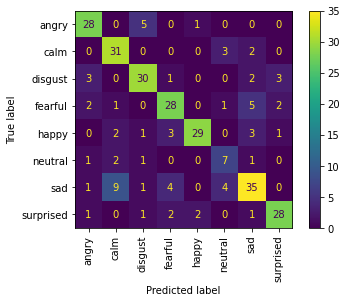

In [183]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(xticks_rotation='vertical')

In [184]:
ravdess_df['emotion'].value_counts()

surprised    192
fearful      192
sad          192
angry        192
disgust      192
calm         192
happy        192
neutral       96
Name: emotion, dtype: int64

In [185]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.78      0.82      0.80        34
        calm       0.69      0.86      0.77        36
     disgust       0.77      0.77      0.77        39
     fearful       0.74      0.72      0.73        39
       happy       0.91      0.74      0.82        39
     neutral       0.47      0.58      0.52        12
         sad       0.71      0.65      0.68        54
   surprised       0.82      0.80      0.81        35

    accuracy                           0.75       288
   macro avg       0.74      0.74      0.74       288
weighted avg       0.76      0.75      0.75       288



Et. al Khalaf [ref](https://www.researchgate.net/figure/Comparison-of-state-of-the-art-and-proposed-models-using-RAVDESS-database-eight_tbl1_349448074) in August 2020 calimed that the state of the art models in audio emotion recognition task on RAVDESS received 79.5%

In [186]:
# clf.score(X_test, y_test)

In [156]:
# clf.score(X_train, y_train)